<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a>
</p>
<p align="center">
<a href="https://discord.gg/AMApC2UzVY"><img alt="Discord" src="https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord"></a>
<a href="https://twitter.com/vlmrun"><img alt="Twitter Follow" src="https://img.shields.io/twitter/follow/vlmrun.svg?style=social&logo=twitter"></a>
</p>
</div>

Welcome to **[VLM Run Cookbooks](https://github.com/vlm-run/vlmrun-cookbook)**, a comprehensive collection of examples and notebooks demonstrating the power of structured visual understanding using the [VLM Run Platform](https://app.vlm.run). 

## Case Study: Understanding TV news

In this notebook, we'll walk through an example of understanding the content of TV news using VLM Run's specialized `media.tv-news` domain

### Environment Setup

To get started, install the VLM Run Python SDK and sign-up for an API key on the [VLM Run App](https://app.vlm.run).
- Store the VLM Run API key under the `VLMRUN_API_KEY` environment variable.

## Prerequisites

* Python 3.9+
* VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))

## Setup

First, let's install the required packages:

In [1]:
! pip install vlmrun --upgrade --quiet
! pip install vlmrun-hub --upgrade --quiet

In [2]:
!pip install pytube opencv-python numpy --quiet

In [3]:
import os
import getpass

VLMRUN_BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://dev.vlm.run/v1")
VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass()

 ········


Let's initialize the VLM Run Client

In [4]:
from vlmrun.client import VLMRun

vlm_client = VLMRun(base_url=VLMRUN_BASE_URL, api_key=VLMRUN_API_KEY)

## Understand news videos on YouTube

Now, let's mine tv news video from Youtube and use VLM Run Client to fetch structured data using the `media.tv-news` domain

In [6]:
from IPython.display import HTML, display

URL = "https://www.youtube.com/watch?v=JDRCLKIosHg"

_, yt_id = URL.split("?v=")
IFRAME_STR = f'<iframe width="560" height="315" src="https://www.youtube.com/embed/{yt_id}?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>'
display(HTML(IFRAME_STR))

print(URL)

https://www.youtube.com/watch?v=JDRCLKIosHg


In [7]:
import yt_dlp

def download_video(url: str) -> str:
    ydl_opts = {
        'format': 'best[ext=mp4]',
        'quiet': True,
        'no_warnings': True,
    }
    
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        video_path = ydl.prepare_filename(info)
        return video_path

In [8]:
# Download the youtube video
video_path = download_video(URL)
print(video_path)

Musk Offers $97.4 Billion for Control of OpenAI： WSJ [JDRCLKIosHg].mp4


Implement a generator that samples a frame every 5 seconds from the video

In [9]:
from typing import Iterator
import cv2
from PIL import Image
from datetime import timedelta

def frame_generator(video_path: str, interval_seconds: int = 5) -> Iterator[tuple[float, Image.Image]]:
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Could not open video file")

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = total_frames / fps

        total_intervals = int(duration) // interval_seconds
        current_interval = 0
        
        print(f"Video info: {duration:.1f}s, {fps:.1f}fps, {total_frames} frames")
        
        for second in range(0, int(duration), interval_seconds):
            cap.set(cv2.CAP_PROP_POS_MSEC, second * 1000)
            ret, frame = cap.read()
            
            if not ret:
                break
                
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            
            yield second, pil_image

            current_interval += 1
            progress = (second / duration) * 100
            frames_remaining = total_intervals - current_interval
            
            print(f"Progress: {progress:.1f}% | Frame: {current_interval}/{total_intervals}")
    
    finally:
        cap.release()

### Let's define some utility functions for visualization

In [10]:
from IPython.display import display, HTML
import pandas as pd
from datetime import timedelta

def display_analysis(timestamp: float, frame: Image.Image, response: dict):
    time_str = str(timedelta(seconds=int(timestamp)))
    
    html = f"""
    <div style="border: 1px solid #ddd; padding: 15px; margin: 10px 0; border-radius: 8px; background-color: #f8f9fa;">
        <h3 style="color: #2c3e50;">Timestamp: {time_str}</h3>
        <div style="display: flex; gap: 20px; align-items: start;">
            <div style="flex: 1;">
                <img src="data:image/jpeg;base64,{frame_to_base64(frame)}" 
                     style="max-width: 100%; height: auto; border-radius: 4px;">
            </div>
            <div style="flex: 1;">
                <table style="width: 100%; border-collapse: collapse;">
                    <tr style="background-color: #e9ecef;">
                        <th style="padding: 8px; text-align: left;">Field</th>
                        <th style="padding: 8px; text-align: left;">Content</th>
                    </tr>
                    <tr>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;"><b>Network</b></td>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;">{response['network']}</td>
                    </tr>
                    <tr>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;"><b>Chyron</b></td>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;">{response['chyron']}</td>
                    </tr>
                    <tr>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;"><b>Reporters</b></td>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;">{', '.join(response['reporters']) if response['reporters'] else 'None'}</td>
                    </tr>
                    <tr>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;"><b>Description</b></td>
                        <td style="padding: 8px; border-bottom: 1px solid #dee2e6;">{response['description']}</td>
                    </tr>
                </table>
            </div>
        </div>
    </div>
    """
    display(HTML(html))

def frame_to_base64(frame: Image.Image) -> str:
    import io
    import base64
    
    buffered = io.BytesIO()
    frame.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode()

Video info: 226.2s, 30.0fps, 6779 frames
Progress: 0.0% | Frame: 1/45


Field,Content
Network,None
Chyron,Elon Musk-led group makes $97.4B bid for control of OpenAI: WSJ
Reporters,None
Description,"Two news anchors are on screen, one on the left and the other on the right with the Golden Gate Bridge in the background."

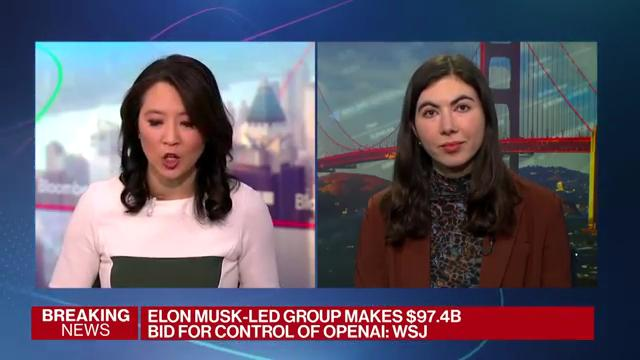

Progress: 2.2% | Frame: 2/45


Field,Content
Network,Bloomberg
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,None
Description,Two reporters are discussing a headline about an Elon Musk-led group making a $97.4 billion bid for control of OpenAI. The background shows a newsroom setup on one side and the Golden Gate Bridge on the other side.

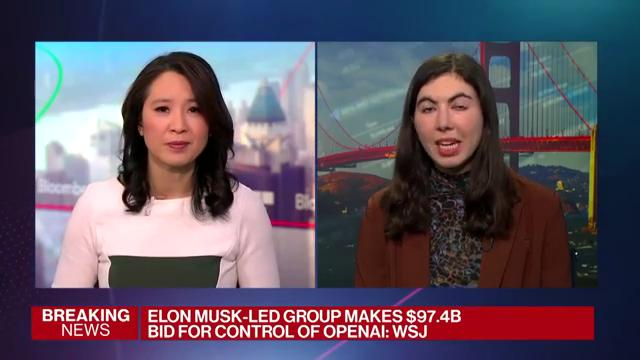

Progress: 4.4% | Frame: 3/45


Field,Content
Network,None
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,None
Description,A news broadcast in front of an image of the Golden Gate Bridge with a chyron at the bottom.

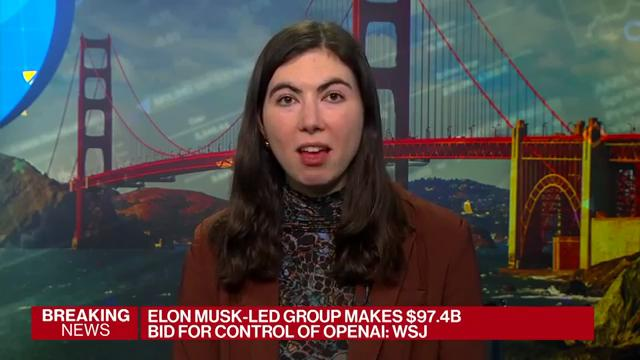

Progress: 6.6% | Frame: 4/45


Field,Content
Network,Bloomberg News
Chyron,Elon Musk-Led Group Makes $97.4B Bid for Control of OpenAI: WSJ
Reporters,Sarah Frier
Description,Sarah Frier reporting live with the Golden Gate Bridge in the background.

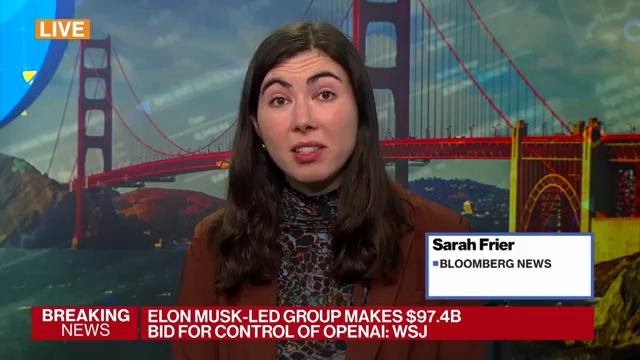

Progress: 8.8% | Frame: 5/45


Field,Content
Network,BLOOMBERG NEWS
Chyron,BREAKING NEWS
Reporters,Sarah Frier
Description,The backdrop features the Golden Gate Bridge. 'LIVE' indicator at the top left corner with 'BREAKING NEWS' ticker at the bottom.

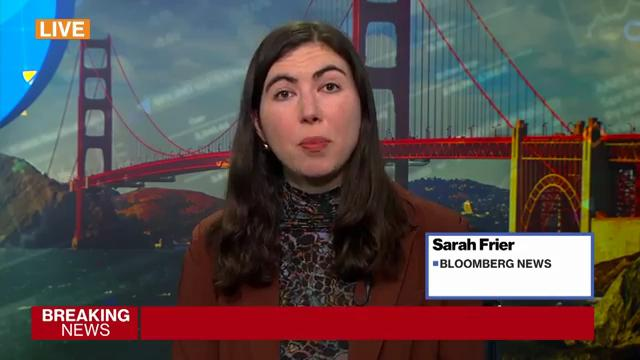

Progress: 11.1% | Frame: 6/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,Sarah Frier reporting live with the Golden Gate Bridge in the background.

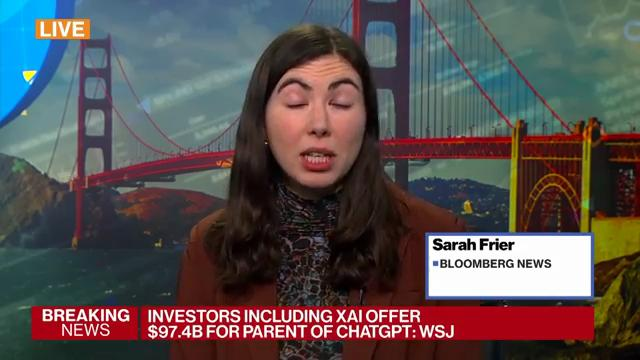

Progress: 13.3% | Frame: 7/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A news broadcast with the Golden Gate Bridge in the background.

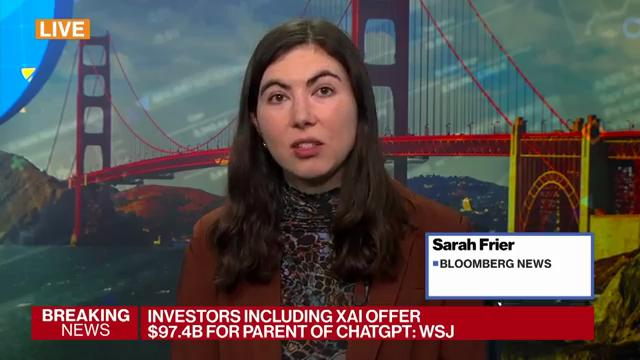

Progress: 15.5% | Frame: 8/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,"A female reporter in front of the Golden Gate Bridge background, with text and chyron overlaid."

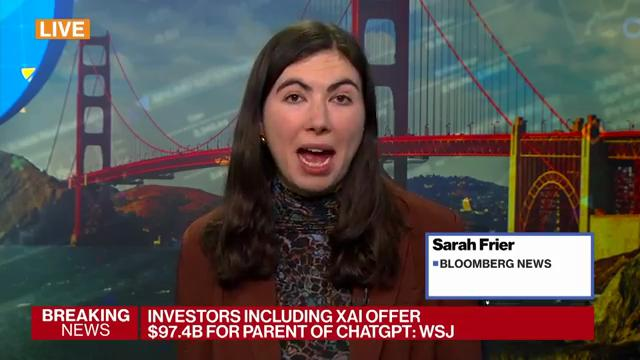

Progress: 17.7% | Frame: 9/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A news anchor standing in front of an image of the Golden Gate Bridge with news ticker information at the bottom of the screen.

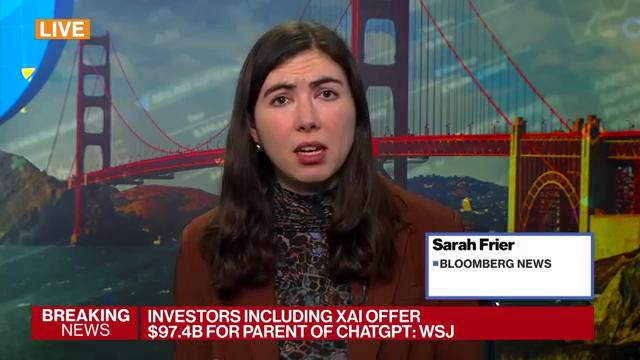

Progress: 19.9% | Frame: 10/45


Field,Content
Network,Bloomberg News
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,Sarah Frier
Description,A news broadcast showing a reporter standing in front of a background image of the Golden Gate Bridge with 'LIVE' indicator.

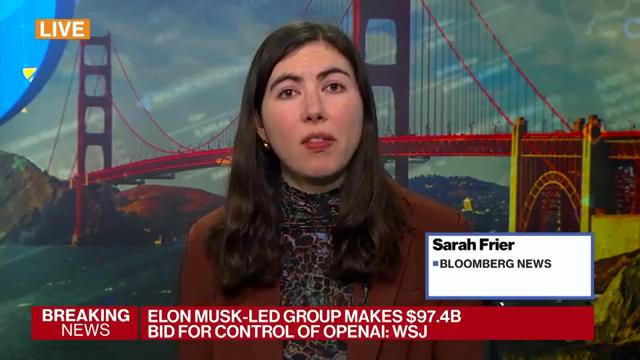

Progress: 22.1% | Frame: 11/45


Field,Content
Network,None
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,None
Description,"Two individuals in a split-screen shot, one on the left in a dark jacket and white shirt, the one on the right in a blue suit. The chyron at the bottom of the screen displays breaking news about an Elon Musk-led group making a $97.4 billion bid for control of OpenAI, as reported by WSJ."

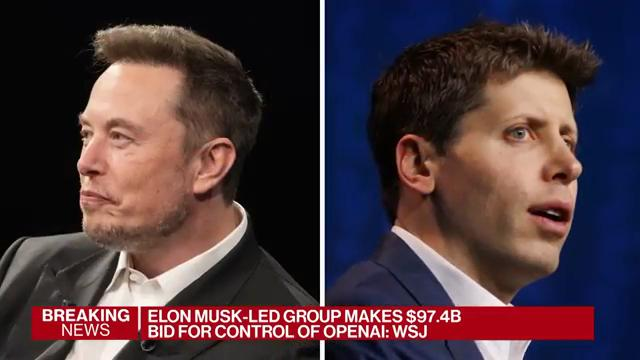

Progress: 24.3% | Frame: 12/45


Field,Content
Network,None
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,None
Description,"Two individuals are shown in a split-screen format; one is holding a microphone while sitting in a formal setting, and the other is seated casually in a room with a brick wall background."

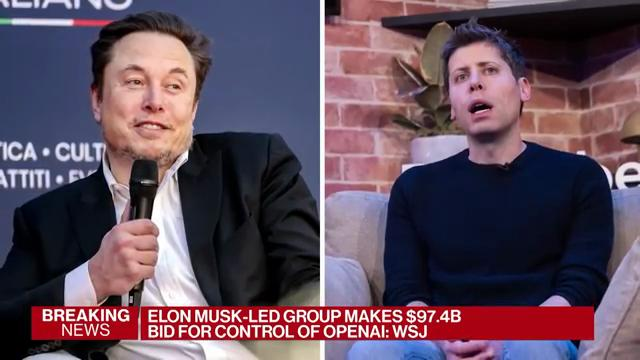

Progress: 26.5% | Frame: 13/45


Field,Content
Network,None
Chyron,Breaking News: Elon Musk-led group makes $97.4B bid for control of OpenAI: WSJ
Reporters,None
Description,"Two individuals in a split-screen format. One is speaking into a microphone wearing a black shirt and jacket on the left, and the other is gesturing while speaking, wearing a white shirt and blue jacket on the right."

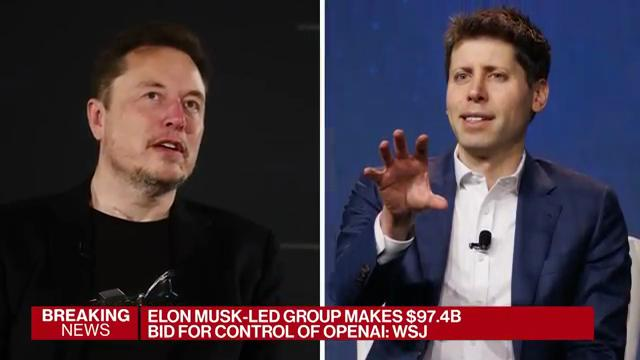

Progress: 28.7% | Frame: 14/45


Field,Content
Network,None
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,None
Description,Split screen with two individuals shown side by side.

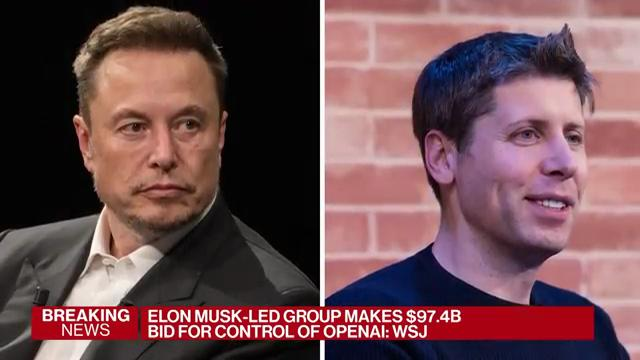

Progress: 30.9% | Frame: 15/45


Field,Content
Network,None
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,None
Description,"Two individuals on a split screen. The one on the left is wearing a dark suit and white shirt, while the one on the right is wearing a blue suit and white shirt."

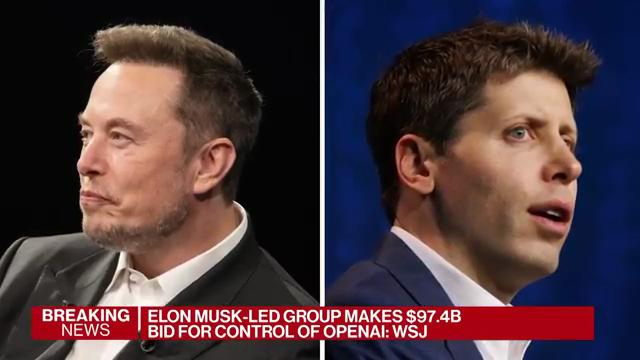

Progress: 33.2% | Frame: 16/45


Field,Content
Network,NBC News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,Two reporters are discussing a news headline related to investments in ChatGPT's parent company. The background shows cityscapes.

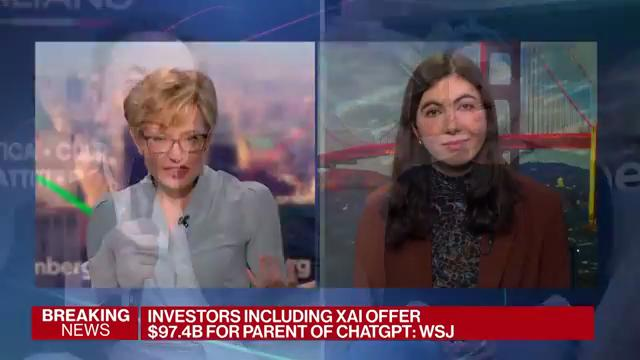

Progress: 35.4% | Frame: 17/45


Field,Content
Network,Bloomberg
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,Two reporters are shown on a split screen with a backdrop of a cityscape and the Golden Gate Bridge. They are discussing news related to an investment offer for the parent company of ChatGPT.

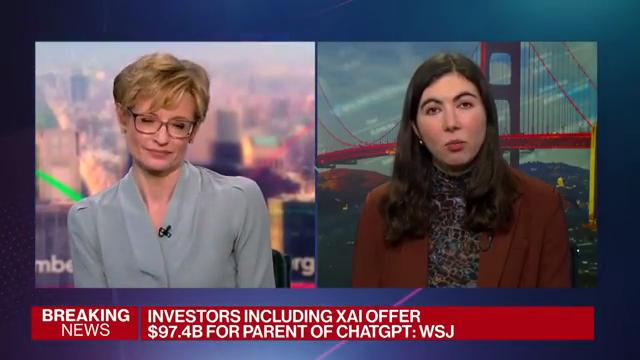

Progress: 37.6% | Frame: 18/45


Field,Content
Network,Bloomberg
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,Reporter in front of a backdrop showing the Golden Gate Bridge.

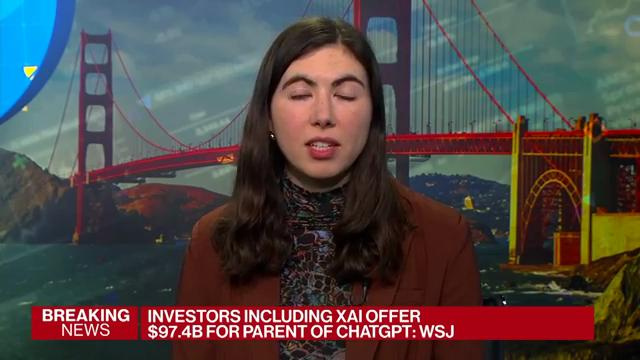

Progress: 39.8% | Frame: 19/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,A news reporter is in front of a backdrop featuring the Golden Gate Bridge.

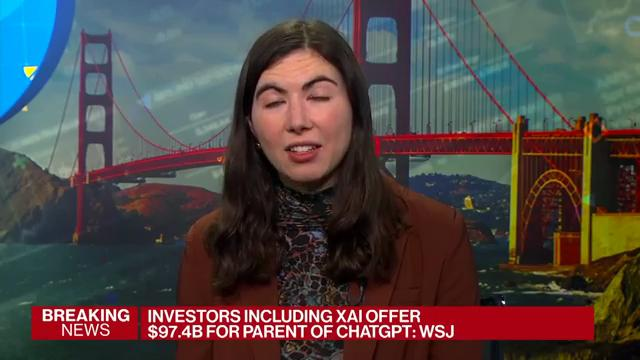

Progress: 42.0% | Frame: 20/45


Field,Content
Network,Bloomberg News
Chyron,BREAKING NEWS: Investors including XAI offer $97.4B for parent of ChatGPT: WSJ
Reporters,Sarah Frier
Description,A reporter is standing in front of a backdrop showing the Golden Gate Bridge during a live news broadcast.

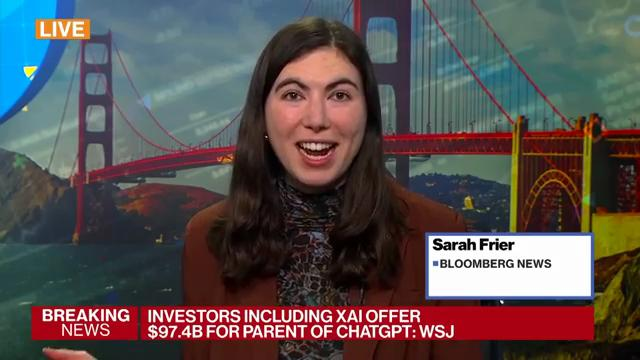

Progress: 44.2% | Frame: 21/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A news broadcast with a backdrop of the Golden Gate Bridge. The chyron displays breaking news about investors including XAI offering $97.4B for the parent of ChatGPT according to WSJ.

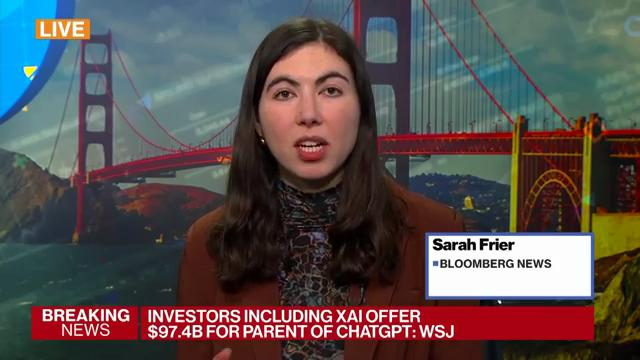

Progress: 46.4% | Frame: 22/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A news broadcast set in front of the Golden Gate Bridge with a lower third displaying breaking news.

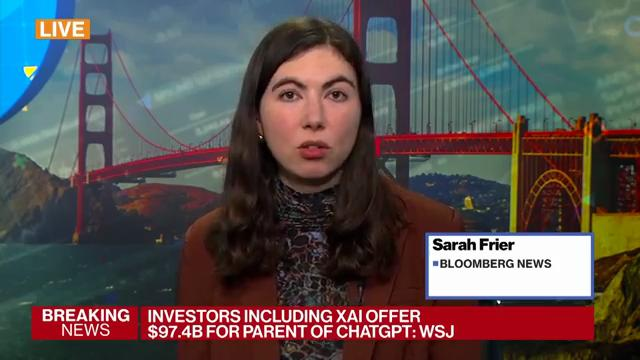

Progress: 48.6% | Frame: 23/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,Sarah Frier from Bloomberg News is reporting with the Golden Gate Bridge in the background. A chyron at the bottom of the screen displays breaking news.

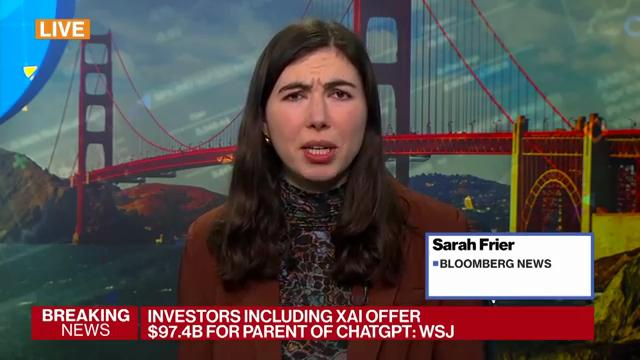

Progress: 50.8% | Frame: 24/45


Field,Content
Network,BLOOMBERG NEWS
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A female reporter in front of a background showing the Golden Gate Bridge.

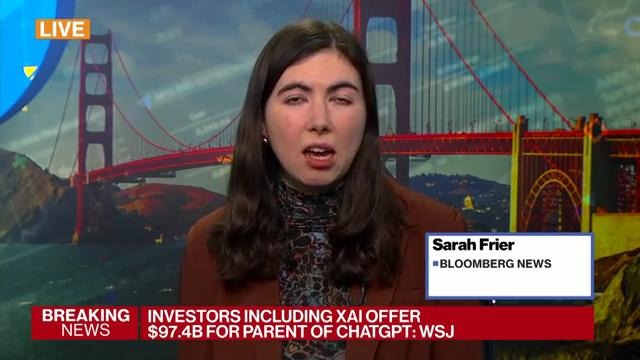

Progress: 53.1% | Frame: 25/45


Field,Content
Network,Bloomberg News
Chyron,BREAKING NEWS - Investors including XAI offer $97.4B for parent of ChatGPT: WSJ
Reporters,Sarah Frier
Description,News reporter standing with the Golden Gate Bridge in the background

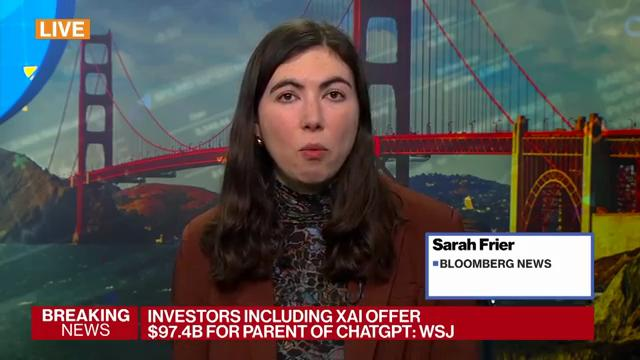

Progress: 55.3% | Frame: 26/45


Field,Content
Network,Bloomberg News
Chyron,Investors including XAI offer $97.4B for parent of ChatGPT: WSJ
Reporters,Sarah Frier
Description,A news anchor standing in front of an image of the Golden Gate Bridge with a chyron mentioning investor news.

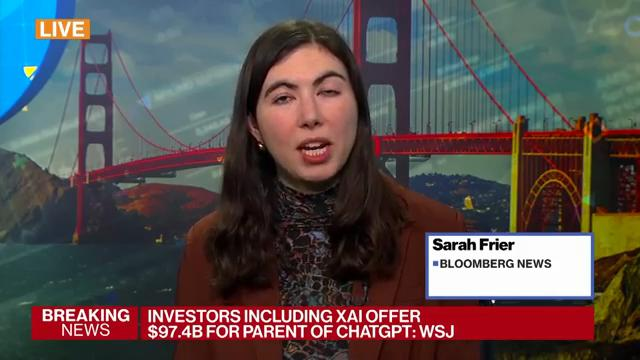

Progress: 57.5% | Frame: 27/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,A news broadcast with the Golden Gate Bridge in the background.

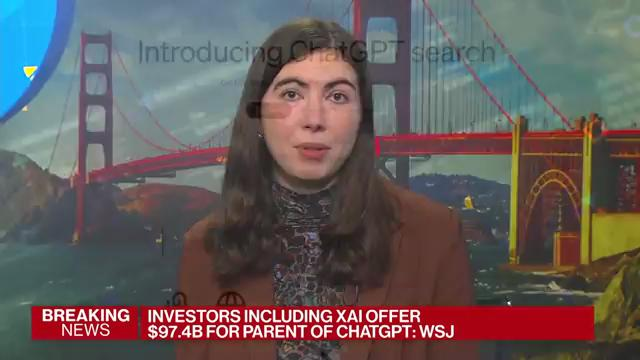

Progress: 59.7% | Frame: 28/45


Field,Content
Network,None
Chyron,Investors including XAI offer $97.4B for parent of ChatGPT: WSJ
Reporters,None
Description,"Screenshot of a webpage introducing ChatGPT search from October 31, 2024 with a chyron at the bottom."

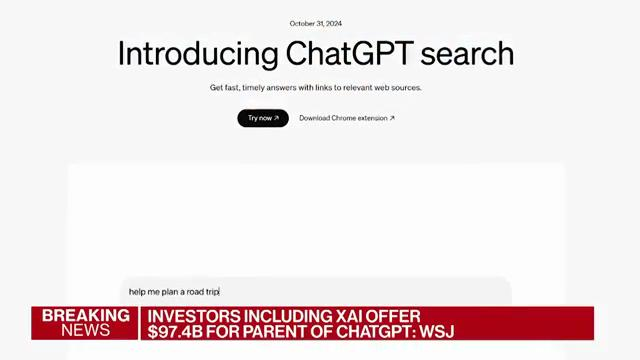

Progress: 61.9% | Frame: 29/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,"Document displayed with points highlighting Amalfi's history, Ravello's elegance, driving considerations for the SS163 road, and local cuisine highlights."

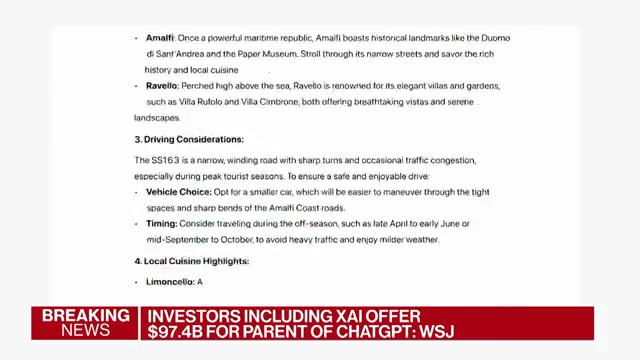

Progress: 64.1% | Frame: 30/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,"An email or document screenshot listing accommodations in Positano, along with a suggestion for the perfect 10-day itinerary to the Amalfi Coast. There are two accommodation options mentioned: Hotel Poseidon and Villa Rosa."

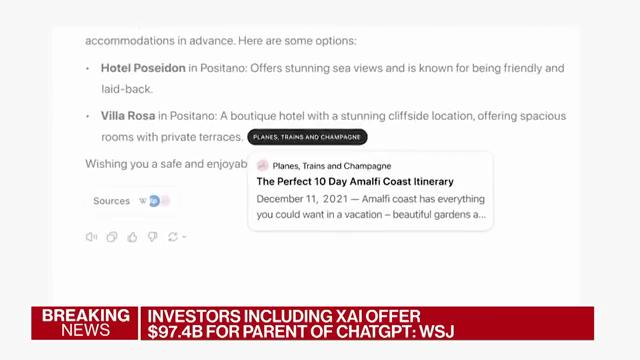

Progress: 66.3% | Frame: 31/45


Field,Content
Network,None
Chyron,Investors including XAI offer $97.4B for parent of ChatGPT: WSJ
Reporters,None
Description,"Screenshot showing recommendations for dining in Positano with featured restaurants La Tagliata and Il Ritrovo, including their descriptions and images."

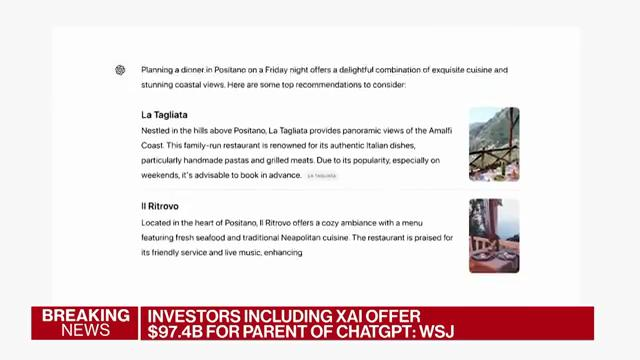

Progress: 68.5% | Frame: 32/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,"A news screen showing the announcement of ChatGPT search on October 31, 2024, with a link to download a Chrome extension."

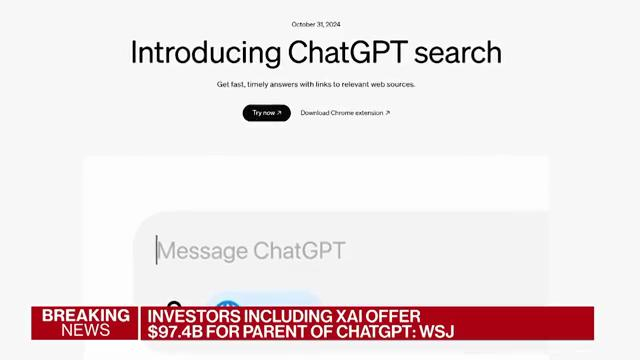

Progress: 70.7% | Frame: 33/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,Screenshot showing an announcement introducing ChatGPT search with the chyron indicating breaking news of a $97.4B offer for the parent of ChatGPT.

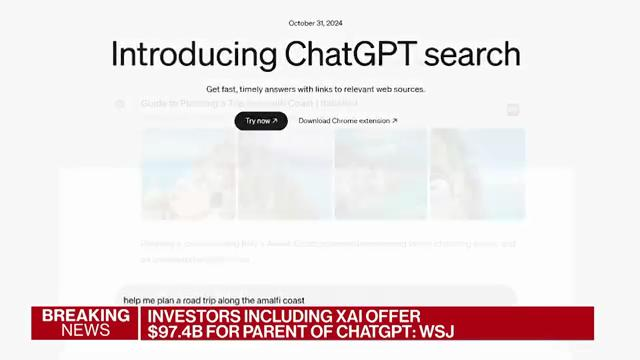

Progress: 72.9% | Frame: 34/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,"Two news anchors are discussing a topic on a split screen, with one anchor located against a backdrop of financial district buildings and the other against a backdrop of the Golden Gate Bridge."

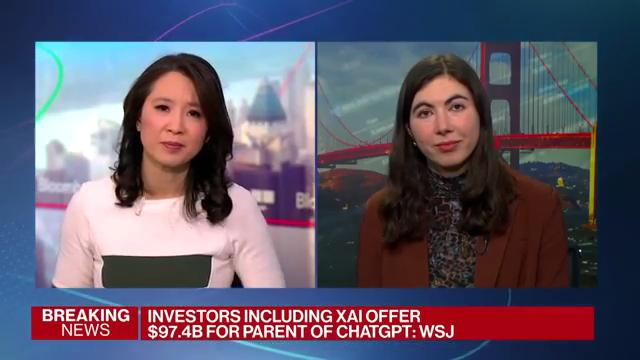

Progress: 75.2% | Frame: 35/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,A news reporter standing in front of a background featuring the Golden Gate Bridge. The lower third of the screen shows a chyron with breaking news.

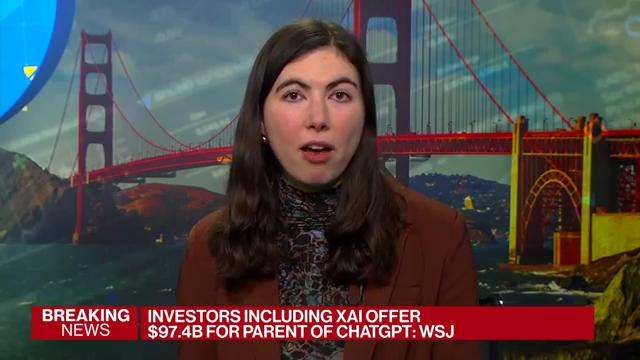

Progress: 77.4% | Frame: 36/45


Field,Content
Network,None
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,None
Description,A news broadcast with the Golden Gate Bridge in the background.

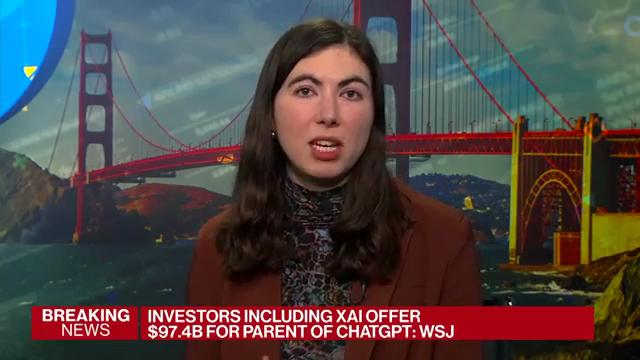

Progress: 79.6% | Frame: 37/45


Field,Content
Network,BLOOMBERG NEWS
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,"A news broadcast with the Golden Gate Bridge in the background, featuring a reporter discussing breaking news about an investment offer for the parent of ChatGPT."

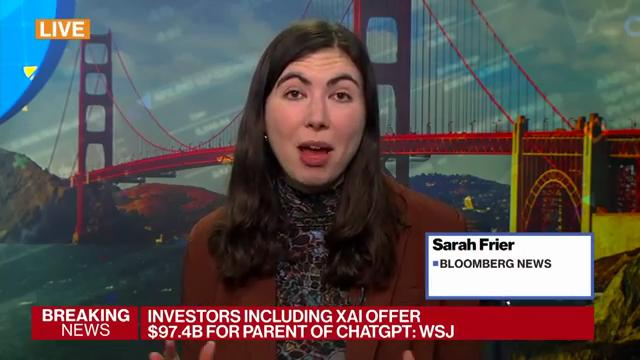

Progress: 81.8% | Frame: 38/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A reporter standing in front of an image of the Golden Gate Bridge.

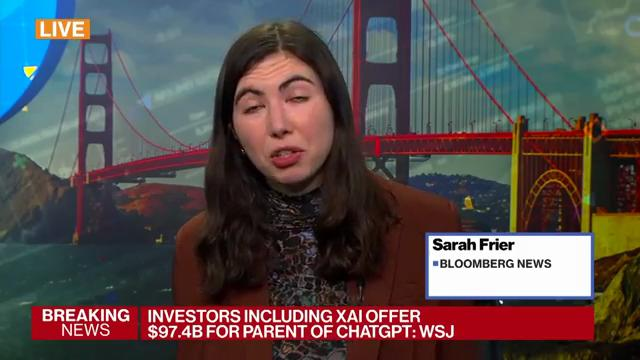

Progress: 84.0% | Frame: 39/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A news broadcast scene featuring Sarah Frier from Bloomberg News with the Golden Gate Bridge in the background. The chyron provides financial news.

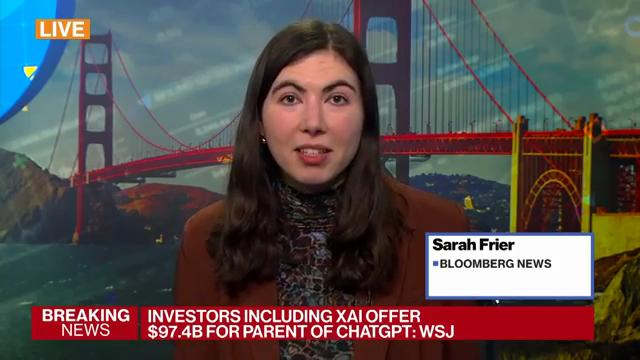

Progress: 86.2% | Frame: 40/45


Field,Content
Network,Bloomberg News
Chyron,BREAKING NEWS INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,"News broadcast with a background of the Golden Gate Bridge. Text 'LIVE' is displayed in the top left corner. Below, the chyron reads 'BREAKING NEWS INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ'."

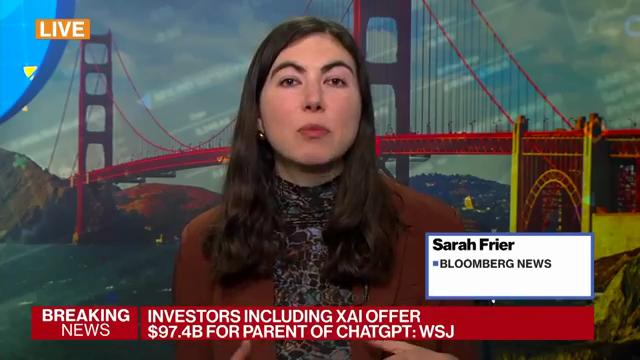

Progress: 88.4% | Frame: 41/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,A news broadcast featuring a female reporter standing in front of a backdrop of the Golden Gate Bridge. The chyron indicates a breaking news story about an investor group including XAI offering $97.4B for the parent company of ChatGPT.

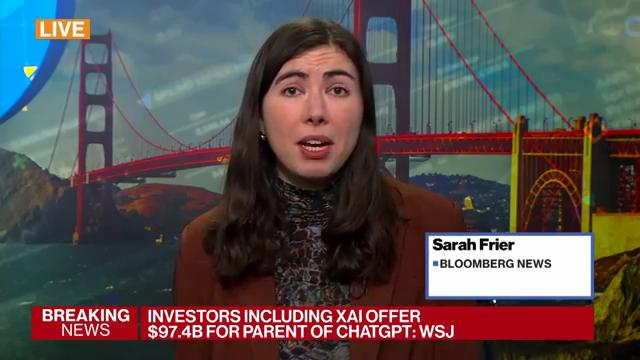

Progress: 90.6% | Frame: 42/45


Field,Content
Network,Bloomberg News
Chyron,INVESTORS INCLUDING XAI OFFER $97.4B FOR PARENT OF CHATGPT: WSJ
Reporters,Sarah Frier
Description,"Reporter standing in front of a backdrop featuring the Golden Gate Bridge, discussing news about investors including XAI offering $97.4B for the parent company of ChatGPT."

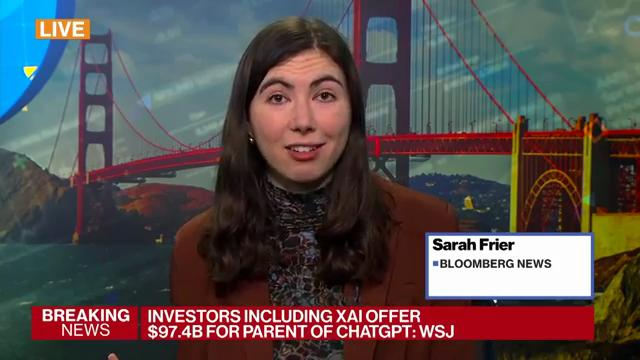

Progress: 92.8% | Frame: 43/45


Field,Content
Network,Bloomberg News
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,Sarah Frier
Description,"An individual standing in front of a backdrop of the Golden Gate Bridge, with a chyron at the bottom of the screen regarding a news story."

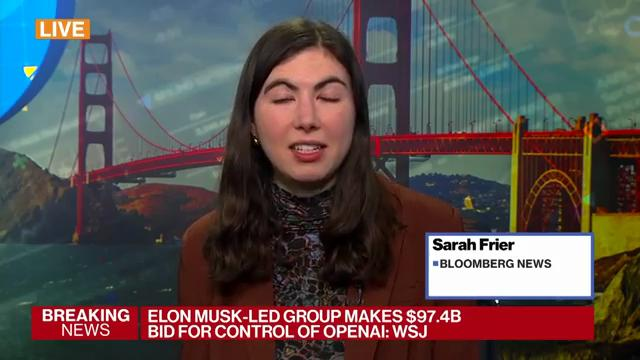

Progress: 95.1% | Frame: 44/45


Field,Content
Network,Bloomberg News
Chyron,ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,Sarah Frier
Description,A news broadcast with a backdrop of the Golden Gate Bridge.

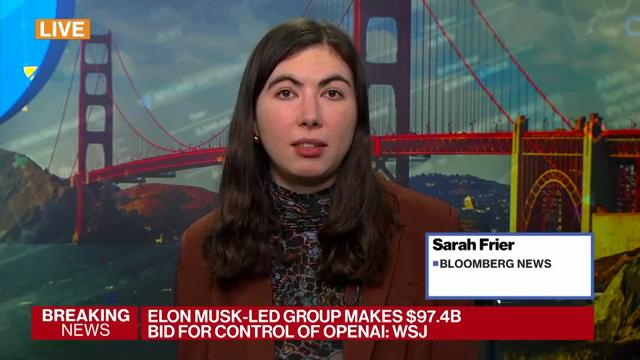

Progress: 97.3% | Frame: 45/45


Field,Content
Network,Bloomberg News
Chyron,BREAKING NEWS: ELON MUSK-LED GROUP MAKES $97.4B BID FOR CONTROL OF OPENAI: WSJ
Reporters,Sarah Frier
Description,An image of a news broadcast featuring a reporter with a backdrop of the Golden Gate Bridge. The chyron highlights breaking news about Elon Musk-led group bidding for control of OpenAI.

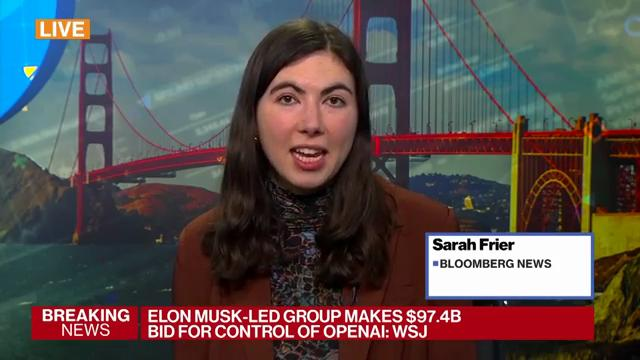

Progress: 99.5% | Frame: 46/45


In [11]:
for idx, (timestamp, frame) in enumerate(frame_generator(video_path)):
    response = vlm_client.image.generate(
        domain="media.tv-news",
        images=[frame]
    )
    
    if idx > 0:
        display_analysis(timestamp, frame, response.response)

## Additional Resources
- [VLM Run Documentation](https://docs.vlm.run)
- [API Reference](https://docs.vlm.run/)
- [More Examples](https://github.com/vlm-run/vlmrun-cookbook)